# Personal VAD architecture evaluation
This notebook serves as a tool for model evaluation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import soundfile as sf
import pickle
from copy import copy
import torch
from personal_vad import PersonalVAD

In [2]:
# first, load the testing dataset and prepare the testing loop
from personal_vad import PersonalVAD, WPL, pad_collate
from vad_et import VadETDataset, VadETDatasetArk
from vad_set import VadSETDatasetArk, VadSETDataset
from vad_st import VadSTDatasetArk, VadSTDataset
from vad_xvector import VadETDatasetArkX
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.metrics import average_precision_score, confusion_matrix
import kaldiio
import os
import ml_metrics as metrics
USE_KALDI = True

In [221]:
# load the model
test_dir = '/home/pirx/Devel/bp/personalVAD/data/train_dir/'
os.chdir(test_dir)

#model = PersonalVAD(input_dim=552, hidden_dim=64, num_layers=2, out_dim=3)
#model.load_state_dict(torch.load('models/final/vad_et_10ep_xvec_l2.pt'))
#test_data = VadETDatasetArkX('data/test', 'embeddings_xvec_l2_non_negative')

#model = PersonalVAD(input_dim=297, hidden_dim=64, num_layers=2, out_dim=3)
#model.load_state_dict(torch.load('models/final/vad_set_tanh_score2_10ep.pt'))
#test_data = VadSETDatasetArk('data/test', 'embeddings', score_type=2)

model = PersonalVAD(input_dim=296, hidden_dim=64, num_layers=2, out_dim=3)
model.load_state_dict(torch.load('models/final/vad_et_10ep_tanh_wpl_0.5.pt'))
##model.load_state_dict(torch.load('models/final/vad_et_10ep_tanh.pt'))
##model.load_state_dict(torch.load('models/final/vad_et_10ep_linear.pt'))
test_data = VadETDatasetArk('data/test', 'embeddings')

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

130563


In [228]:
#FILE = '1_flac/rev1-251-137823-0013_3853-163249-0030_777-126732-0056'

x, y = test_data.__getitem__(664)
print(y.shape)

"""
FILE = '0_concat/887-123290-0008_587-41619-0013_5390-30102-0004'
with np.load('../data/features_old/pvad/test/' + FILE + '.pvad.fea.npz') as f:
    x = f['x']
    embed = f['embed']
    y = f['y']
    #scores = f['scores']
    #x = np.hstack((x, np.expand_dims(scores, 1)))
    x = np.hstack((x, np.full((x.shape[0], 256), embed)))

audio, sr = sf.read('/run/media/pirx/Elements/pirx/personalVAD/data/concat/train_clean_100/' + FILE + '.flac')
"""

new_y = np.kron(y.numpy(), np.ones(160))
#new_x = np.kron(x[:,0] + x[:,1], np.ones(160))

torch.Size([579])


In [229]:
# get the model to generate a label vector for us

conv_filter = np.array([1/8]*8)
conv_filter2 = np.cos([1, 0, -1, 0])

with torch.no_grad():
    x_torch = torch.unsqueeze(x, 0)
    
    softmax = torch.nn.Softmax(dim=1)
    
    if x.shape[0] > 2000 and False:
        stop = 1000
        output_raw1 = torch.squeeze(model(x_torch[:,:stop,:], torch.unsqueeze(torch.tensor(x[:stop,:].shape[0]), dim=0), None)[0])
        output_raw2 = torch.squeeze(model(x_torch[:,stop:,:], torch.unsqueeze(torch.tensor(x[stop:,:].shape[0]), dim=0), None)[0])
        output_raw = torch.cat((output_raw1, output_raw2))
    else:
        output_raw = torch.squeeze(model(x_torch, torch.unsqueeze(torch.tensor(x.shape[0]), dim=0), None)[0])
    
    
    test = False
    output_raw = softmax(output_raw)
    if test:
        output_raw = output_raw.numpy()
        x = output_raw
        b = ((x[:,0] < x[:,1]) | (x[:,0] < x[:,2])).astype('int') # 0 if ns, 1 if speech
        c = ((0.1 * x[:,1]) < x[:,2]).astype('int') # 0 if ntss, 1 if tss

        d = ((b == c) & (c != 0)).astype('int') * 2 #  2 if tss, 0 else
        e = np.where((c == 0) & (b != 0), 1, 0)
        output = torch.from_numpy(d+e)
    else:
        output = torch.argmax(output_raw, dim=1)
        output_raw = output_raw.numpy()
    o0 = np.kron(output_raw[:, 0], np.ones(160))
    o1 = np.kron(output_raw[:, 1], np.ones(160))
    o2 = np.kron(output_raw[:, 2], np.ones(160))
    
    #output_hard = output_raw > 0.5
    ##output_conv = np.convolve(output_raw, conv_filter)
    #output_conv = np.convolve(np.convolve(output_raw, conv_filter), conv_filter2)
    #output_conv_hard = output_conv > 0.5
    o_raw = np.kron(output, np.ones(160))
    #o_hard = np.kron(output_hard, np.ones(160))
    #o_smooth = np.kron(replace_zero_sequences(output_hard, 8), np.ones(160))
    #o_conv = np.kron(output_conv, np.ones(160))

In [230]:
def medfilt (x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median (y, axis=1)

filtered = np.kron(medfilt(output.numpy(), 21), np.ones(160))

Text(0.5, 1.0, 'pravděpodobnost TSS')

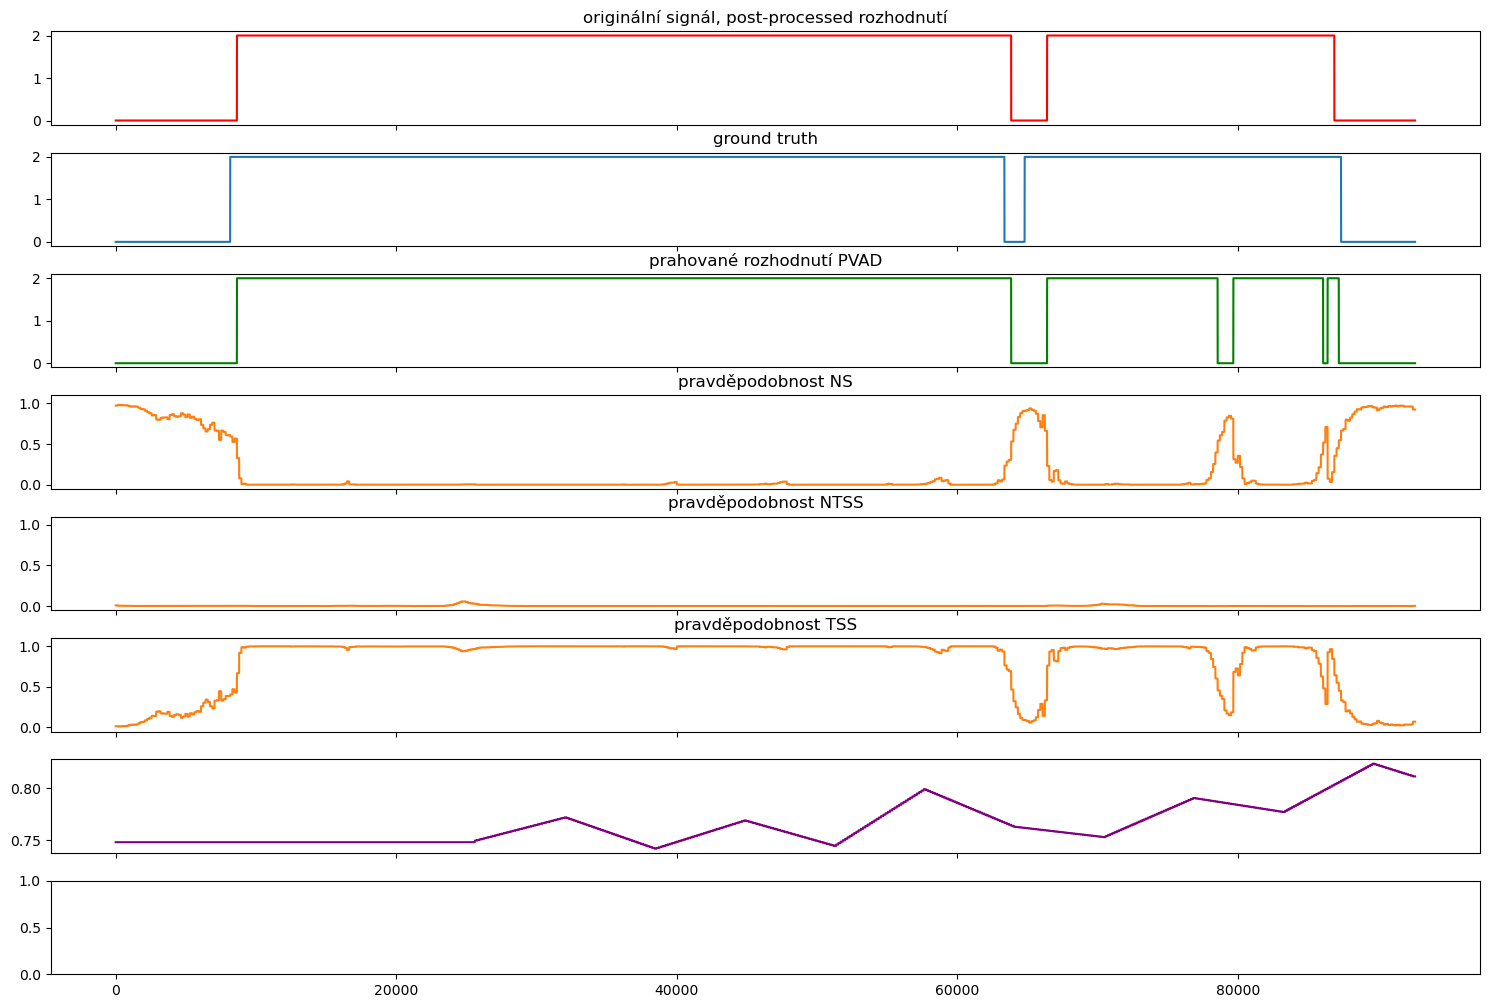

In [231]:
# Plot the original signal and labels plus the first two filterbank coefficients,
# the original shortest sequence and the edited label vector
mpl.style.use('default')
fig, ax = plt.subplots(8, 1, figsize=(15,10), sharex=True)
fig.tight_layout(pad=1.0)

#ax[0].plot(audio + 1)
ax[1].plot(new_y)
##ax[2].plot(new_x)
##ax[3].plot(seq)  # plot the position of the shortest sequence
##ax[2].plot(np.kron(replace_zero_sequences(y, 13), np.ones(160))) # deleted super short sequences
ax[2].plot(o_raw, 'green') # plot the vad prediction
for axes in ax[3:6]:
    axes.set_ylim(-0.05, 1.1)

ax[3].plot(o0, 'C1') # plot the vad hard thresholded decision
ax[4].plot(o1, 'C1') # plot the vad hard thresholded decision with short sequences removed
ax[5].plot(o2, 'C1') # plot the vad filtered decision
if x.shape[1] > 40:
    ax[6].plot(np.kron(x[:,40], np.ones(160)), 'purple') # plot the scores
ax[0].plot(filtered, 'red') # filtered, thresholded

ax[0].set_title('Original signal, post-processed decision')
ax[1].set_title('Ground truth')
ax[2].set_title('PVAD thresholded decision')
ax[3].set_title('NS probability')
ax[4].set_title('NTSS probability')
ax[5].set_title('TSS probability')

## mAP evaluation
Before proceeding, select the evaluated model architecture, score type, and whether to evaluate the model for clean or augmented speech.

Additionally, the model name can be specified in the load_state_dict() function... Take a look in the model directory to see the list of available models....

In [7]:
# change these two based upon the evaluated model..
arch = 'st' # in ['et', 'st', 'set', 'xvec', 'ivec']
score_type = 2 # scoring method.. 0 (baseline), 1 (PC), 2 (LI)

batch_size_test = 64
test_dir = '/home/pirx/Devel/bp/personalVAD/data/train_dir/'
os.chdir(test_dir)

# load the evaluated model and create the corresponding dataset object
if arch == 'et':
    model = PersonalVAD(input_dim=296, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/final/vad_et_10ep_tanh_wpl_0.5.pt'))
    test_data = VadETDatasetArk('data/test_clean', 'embeddings')

elif arch == 'set':
    model = PersonalVAD(input_dim=297, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/final/vad_set_tanh_score1_10ep.pt'))
    test_data = VadSETDatasetArk('data/test', 'embeddings', score_type)

elif arch == 'st':
    model = PersonalVAD(input_dim=41, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/final/vad_st_tanh_score2_8ep.pt'))
    test_data = VadSTDatasetArk('data/test_clean', score_type)
        
elif arch == 'xvec':
    model = PersonalVAD(input_dim=552, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/vad_et_7ep_xvec.pt'))
    test_data = VadETDatasetArkX('data/test_clean', 'embeddings_xvec')
    
elif arch == 'ivec':
    #TODO
    model = PersonalVAD(input_dim=552, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/vad_et_7ep_xvec.pt'))
    test_data = VadETDatasetArkI('data/test_clean', 'embeddings_xvec')
    
else:
    # we should not get here
    model = None
    pass

test_loader = DataLoader(
        dataset=test_data, batch_size=batch_size_test, num_workers=2, shuffle=False, collate_fn=pad_collate)

# set the device to cuda and move the model to the gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [9]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
sigmoid = torch.nn.Sigmoid()
targets = []
outputs = []

#weights = torch.tensor([1.0, 0.1, 1.0]).to(device)
#criterion = WPL(weights)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for x_padded, y_padded, x_lens, y_lens in test_loader:
        y_padded = y_padded.to(device)

        # pass the data through the model
        out_padded, _ = model(x_padded.to(device), x_lens, None)

        # value, index
        for j in range(out_padded.size(0)):
            #loss = criterion(out_padded[j][:y_lens[j]], y_padded[j][:y_lens[j]])
            #print(loss)
            #break
            
            p = softmax(out_padded[j][:y_lens[j]])
            
            outputs.append(p.cpu().numpy())
            targets.append(y_padded[j][:y_lens[j]].cpu().numpy())
                
targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
print(targets.shape)
print(outputs.shape)

/home/pirx/Devel/bp/personalVAD/src/vad_st.py:81: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  y = torch.from_numpy(y).long()
/home/pirx/Devel/bp/personalVAD/src/vad_st.py:81: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pyt

(7575583,)
(7575583, 3)


In [10]:
# convert the target array to one hot
targets_oh = np.eye(3)[targets]

# and run the AP
out_AP = average_precision_score(targets_oh, outputs, average=None)
mAP = average_precision_score(targets_oh, outputs, average='micro')

# print the average precision scores for all classes as well as the micro-averaged mean average precision score
print(out_AP) 
print(f"mAP: {mAP}")

[0.93471805 0.97433739 0.97609702]
mAP: 0.969809300002235


0.9086128420743328

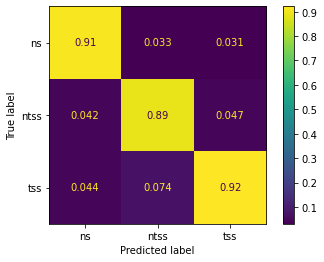

In [12]:
from sklearn.metrics import precision_score, accuracy_score, ConfusionMatrixDisplay
classes = np.argmax(outputs, axis=1)
cm = confusion_matrix(classes, targets, normalize='pred')

# compute and plot the model confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=['ns', 'ntss', 'tss'])
disp.plot()

# compute model accuracy
acc = accuracy_score(classes, targets)
print("accuracy:", acc)

## Baseline VAD evaluation
This part of the notebook allows for baseline VAD system evaluation.

In [18]:
from vad import VadDataset, VadDatasetArk

In [45]:
model = PersonalVAD(input_dim=40, hidden_dim=64, num_layers=2, out_dim=2, linear=False)
model.load_state_dict(torch.load('models/final/vad_tanh_6ep.pt'))
test_data = VadDatasetArk('data/test_clean')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

test_loader = DataLoader(
        dataset=test_data, batch_size=batch_size_test, num_workers=1, shuffle=False, collate_fn=pad_collate)

In [46]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
targets = []
outputs = []

with torch.no_grad():
    for x_padded, y_padded, x_lens, y_lens in test_loader:
        y_padded = y_padded.to(device)

        # pass the data through the model
        out_padded, _ = model(x_padded.to(device), x_lens, None)

        # value, index
        for j in range(out_padded.size(0)):
            p = out_padded[j][:y_lens[j]]
            
            outputs.append(p.cpu().numpy())
            targets.append(y_padded[j][:y_lens[j]].cpu().numpy())
                
targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
print(targets.shape)
print(outputs.shape)

/home/pirx/Devel/bp/personalVAD/src/vad.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  x = torch.from_numpy(x).float()


(7575583,)
(7575583, 2)


In [47]:
# convert the target array to one hot
targets_oh = np.eye(2)[targets.astype(int)]
outputs_oh = np.hstack((1 - outputs, outputs))

# and run the AP
out_AP = average_precision_score(targets_oh, outputs, average=None)
mAP = average_precision_score(targets_oh, outputs, average='micro')

print(out_AP) 
print(f"mAP: {mAP}")
print("accuracy:", accuracy_score(targets, np.argmax(outputs, axis=1)))

[0.94726461 0.99788884]
mAP: 0.9946104658384344
accuracy: 0.963356219580724


# Baseline system

In [62]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

test_dir = '/home/pirx/Devel/bp/personalVAD/data/train_dir/'
os.chdir(test_dir)
class BaselineDataset(Dataset):
    """VadST training dataset. Uses kaldi scp and ark files."""

    def __init__(self, root_dir, score_type):
        self.root_dir = root_dir
        self.score_type = score_type

        self.fbanks = kaldiio.load_scp(f'{self.root_dir}/fbanks.scp')
        self.scores = kaldiio.load_scp(f'{self.root_dir}/scores.scp')
        self.labels = kaldiio.load_scp(f'{self.root_dir}/labels.scp')
        self.keys = np.array(list(self.fbanks)) # get all the keys

    def __len__(self):
        return self.keys.size

    def __getitem__(self, idx):
        key = self.keys[idx]
        x = self.fbanks[key]
        scores = self.scores[key][self.score_type,:]
        y = self.labels[key]

        x = torch.from_numpy(x).float()
        scores = torch.from_numpy(scores).float()
        y = torch.from_numpy(y).long()
        return x, scores, y

def baseline_pad_collate(batch):
    """Padding function used to deal with batches of sequences of variable lengths.

    Returns:
        tuple: A tuple containing:
            
            xx_pad (torch.tensor): Padded feature vector.
            yy_pad (torch.tensor): Padded ground truth vector.
            x_lens (torch.tensor): Lengths of the original feature vectors within the batch.
            y_lens (torch.tensor): Lengths of the original ground truth vectors within the batch.

    """

    (xx, scores, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

    return xx_pad, yy_pad, scores, x_lens, y_lens

In [72]:
model = PersonalVAD(input_dim=40, hidden_dim=64, num_layers=2, out_dim=2, use_fc=True, linear=True)
model.load_state_dict(torch.load('models/final/vad_linear_6ep.pt'))
test_data = BaselineDataset('data/test', 0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

test_loader = DataLoader(
        dataset=test_data, batch_size=64, num_workers=2, shuffle=False, collate_fn=baseline_pad_collate)

In [73]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
sigmoid = torch.nn.Sigmoid()
targets = []
outputs = []
is_tss = []

with torch.no_grad():
    for x_padded, y_padded, scores, x_lens, y_lens in test_loader:
        # pass the data through the model
        out_padded, _ = model(x_padded.to(device), x_lens, None)

        # value, index
        for j in range(out_padded.size(0)):
            score = scores[j]
            x = out_padded[j][:y_lens[j]].cpu()
            x = softmax(x)
            
            # now combine the scores with the vad probability to obtain class probabilities
            ns = x[:,0]
            ntss = x[:,1] * (1 - score)
            tss = x[:,1] * score
            
            """
            print(ns[200:220])
            print(ntss[200:220])
            print(tss[200:220])
            """
            
            x2 = x.numpy()
            score2 = score.numpy()
            b = (x2[:,0] < x2[:,1]).astype('int') # 0 if ns, 1 if speech
            c = (score2 > 0.5329).astype('int') # 0 if ntss, 1 if tss
            
            d = ((b == c) & (b != 0)).astype('int') * 2 #  2 if tss, 0 else
            e = np.where((c == 0) & (b != 0), 1, 0)
            is_tss.append(d + e)
            
            out = torch.stack((ns, ntss, tss)).T
            
            out = softmax(out)
            """
            print(out[200:220,:])
            print(score[200:220])
            print(y_padded[j][:y_lens[j]][200:220])
            """
            outputs.append(out.numpy())
            targets.append(y_padded[j][:y_lens[j]].numpy())
                
targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
is_tss = np.concatenate(is_tss)
print(targets.shape)
print(outputs.shape)

<ipython-input-62-362225e0314a>:27: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  x = torch.from_numpy(x).float()
<ipython-input-62-362225e0314a>:27: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tenso

(30302332,)
(30302332, 3)


In [65]:
# convert the target array to one hot
targets_oh = np.eye(3)[targets]

# and run the AP
out_AP = average_precision_score(targets_oh, outputs, average=None)
mAP = average_precision_score(targets_oh, outputs, average='micro')

print(out_AP) 
print(f"mAP: {mAP}")
print("accuracy:", accuracy_score(targets, np.argmax(outputs, axis=1)))

[0.94794836 0.96409969 0.96492579]
mAP: 0.8658365408073597
accuracy: 0.7491051183783479


In [74]:
acc = (targets == is_tss).sum() / targets.size
print(acc)
from sklearn.metrics import precision_score

classes = np.argmax(outputs, axis=1)
print(precision_score(targets, classes, average='micro'))

0.7446200840252163
0.7209467574970798
